<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Comparing-SMEs:-Inflation,-policies-and-distribution" data-toc-modified-id="Comparing-SMEs:-Inflation,-policies-and-distribution-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Comparing SMEs: Inflation, policies and distribution</a></span><ul class="toc-item"><li><span><a href="#Preliminaries" data-toc-modified-id="Preliminaries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preliminaries</a></span></li><li><span><a href="#Policy-functions-and-inflation" data-toc-modified-id="Policy-functions-and-inflation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Policy functions and inflation</a></span></li><li><span><a href="#Observation-0" data-toc-modified-id="Observation-0-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Observation 0</a></span></li><li><span><a href="#Observation-1" data-toc-modified-id="Observation-1-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Observation 1</a></span></li><li><span><a href="#Observation-2" data-toc-modified-id="Observation-2-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Observation 2</a></span></li><li><span><a href="#Observation-3" data-toc-modified-id="Observation-3-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Observation 3</a></span></li><li><span><a href="#Observation-4" data-toc-modified-id="Observation-4-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Observation 4</a></span></li><li><span><a href="#Observation-5:" data-toc-modified-id="Observation-5:-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Observation 5:</a></span></li><li><span><a href="#Observation-6:" data-toc-modified-id="Observation-6:-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Observation 6:</a></span></li></ul></li></ul></div>

# Comparing SMEs: Inflation, policies and distribution

[Timothy Kam](https://phantomachine.github.io/)

In [1]:
from __future__ import print_function, division, absolute_import
import sys, os
import socket
import time
import numpy as np
# import matplotlib
# matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import blended_transform_factory
from scipy.stats import skew, kurtosis
from set_batch_parameters import *      # Define parameter combinations here
from cssegmod import basemod as model   # Model class
from scipy.interpolate import UnivariateSpline
import warnings
warnings.filterwarnings('ignore')

Purpose:

Visualization of policy functions and distributions for different inflation policies.

* This notebook uses data saved from running ``COMPARE_STEADYSTATES.IPYNB`` 

    * Uses class ``COMPARESTEADYSTATES_MONTY_FUTURE.PY``

    * Compare SME outcomes across different inflation rates $\tau$

    * Each SME outcome is computed by simulation over a single agent for a very long horizon


* See ``COMPARESTEADYSTATES_MONTY_FUTURE.PY`` for more results that also uses a panel of agents

In [2]:
# This number corresponds to after running COMPARE_STEADYSTATES.IPYNB
N_experiments = 23

In [3]:
# Instantiate model class
klmod = model(m_gridsize_ltk = 24, m_gridsize_gtk = 48)

# Choose interpolation class
klmod.InterpMethod = 'slinear'

In [4]:
# Path to saved experiments
path='comparemonty2future/benchmark/out/'

In [5]:
# ================= EXTERNALLY CALIBRATED PARAMETERS HERE ==============
beta_freq = 'Q'

# tau label (annual)
tau_scale = 4.0

# Inflation and interest rates from annual data
# Lucas and Nicolini, annual 3-mth T-bill-rate mean = 3.4% p/a
# FRED CPI inflation rate 3.9% p/a
# Sample: 1915 to 2007
tau_data_annual = 0.034329539689549854
i_data_annual = 0.03854204301075268
beta_annual  = (1. + tau_data_annual)/(1. + i_data_annual)
if beta_freq == 'Q':
    tau_data = (1.0 + 0.034)**0.25 - 1.0
    i_data = (1.0 + 0.039)**0.25 - 1.0
elif beta_freq == 'A':
    tau_data = tau_data_annual
    i_data = i_data_annual
beta = (1. + tau_data)/(1. + i_data)

In [6]:
# Experiment 
tau_before = 0.0
tau_after = 0.025
# List to be appended to PARAMS below
tau_specifics = [tau_data, tau_before, 0.0025, 0.0125, tau_after]
params = set_batch_parameters(BETA=beta, 
                                Npoints=N_experiments+1, 
                                tau_specifics=tau_specifics,
                                shortsell=True)
xkey = 'tau'
xdata={xkey : [ np.asarray(params)[:,2], 'Money Growth Rate, ' + r"$\tau$" ] }

In [7]:
# Get list of inflation rates as Numpy array
tau_list = np.array(params)[:,-1]
# Location of τ = 0
tau_zero = tau_list.tolist().index(0.0)
# Now restrict example to two experiments: τ ∈ {0, 0.025}
τ_select_compare = [0.0, 0.025]
# Possible styles
linestyles = ["-", "--", "-.", "-x"]
markerstyles = ["o", "s", "d", "p"]
colorstyles = ["b", "r", "m", "g"]
τ_index_experiments = [idx for idx in range(len(tau_list)) 
                        if tau_list[idx] in τ_select_compare]

In [8]:
# Storage dictionary
policies = {
            "l": [], "y": [], "b": [], "q": [], "x": [], "bxm": [], "p": [],
            "elasticity": {
                            "l": [], "y": [], "b": [], "q": [], 
                            "x": [], "bxm": []
                          },
            "tau": [],
           }

distro = {
            "l_CM"    : [],
            "m_CM"    : [],
            "m"       : [],
            "m_mean_CM": [],
            "m_mean"  : [],
            "m_mean_all": [],
            "m_10"    : [],
            "m_50"    : [],
            "m_90"    : [],
            "b"       : [],
            "b_mean"  : [],
            "b_10"    : [],
            "b_50"    : [],
            "b_90"    : [],
            "x"       : [],
            "x_mean"  : [],
            "x_10"    : [],
            "x_50"    : [],
            "x_90"    : [],
            "p"       : [],
            "bxm"     : [],
            "bxm_mean"   : [],
            "bxm_10"     : [],
            "bxm_50"     : [],
            "bxm_90"     : [],
}


# Loop to extract DM variables and construct moments of interest
for experiment in τ_index_experiments:
    # Get results.npy file for experiment
    file=path+'experiment'+str(experiment)+'/results.npy'
    results = np.load(file, encoding='latin1', allow_pickle=True).item()
    
    # Current τ
    policies["tau"].append(tau_list[experiment]*tau_scale)
    
    # Fitted value functions
    value_functions = results['valuefit']
    Vbarfit = value_functions['Vbar']
    Vfit = value_functions['V']
    Bfit = value_functions['B']
    Wfit = value_functions['W']

    # Policy functions evaluated on grid
    policy_functions = results['policygrid']
    lstar = policy_functions['lstar']
    
    # normalized grid
    m_set = klmod.m_grid/klmod.m_grid.max() 
    
      # Finer grid
    m = np.linspace(m_set.min(), m_set.max(), 500)
    
    lfit = klmod.InterpFun1d( m_set, lstar)
    policies["l"].append([ r"$l^{\star}$", lstar, lfit, lfit(m) ])
    ystar = policy_functions['ystar']
    yfit = klmod.InterpFun1d(m_set, ystar)
    policies["y"].append([ r"$y^{\star}$", ystar, yfit, yfit(m) ])
    bstar = policy_functions['bstar']
    bfit = klmod.InterpFun1d( m_set, bstar)
    policies["b"].append([ r"$b^{\star}$", bstar, bfit, bfit(m) ])
    qstar = policy_functions['qstar']
    qfit = klmod.InterpFun1d( m_set, qstar)
    policies["q"].append([ r"$q^{\star}$", qstar, qfit, qfit(m) ])
    xstar = policy_functions['xstar']
    xfit = klmod.InterpFun1d( m_set, xstar)
    policies["x"].append([ r"$x^{\star}$", xstar, xfit, xfit(m) ])
    # m = klmod.m_grid.copy()
    # m[0] = 1e-6
    bxm = bstar*xstar/m_set
    bxmfit = klmod.InterpFun1d(m_set, bxm)
    policies["bxm"].append([ r"$b^{\star}\circ x^{\star}/m$", 
                             bxm, 
                             bxmfit, 
                             bxmfit(m) ])
    
    p = xstar/qstar
    pfit = klmod.InterpFun1d(m_set, p)
    policies["p"].append([ r"$p$", p, pfit, pfit(m) ])

    
    # Policies - Elasticities of interest
    lp = lfit.derivative()(m_set)
    e_l = klmod.InterpFun1d(m_set, lp*m_set/lfit(m_set))
    policies["elasticity"]["l"].append([ r"$l^{\star}$", 
                                        e_l(m_set), e_l, e_l(m)])
    yp = yfit.derivative()(m_set)
    e_y = klmod.InterpFun1d(m_set, yp*m_set/yfit(m_set))
    policies["elasticity"]["y"].append([ r"$y^{\star}$", 
                                        e_y(m_set), e_y, e_y(m)])
    bp = bfit.derivative()(m_set)
    e_b = klmod.InterpFun1d(m_set, bp*m_set/bfit(m_set))
    policies["elasticity"]["b"].append([ r"$b^{\star}$", 
                                        e_b(m_set), e_b, e_b(m)])
    qp = qfit.derivative()(m_set)
    e_q = klmod.InterpFun1d(m_set, qp*m_set/qfit(m_set))
    policies["elasticity"]["q"].append([ r"$q^{\star}$", 
                                        e_q(m_set), e_q, e_q(m)])
    xp = xfit.derivative()(m_set)
    e_x = klmod.InterpFun1d(m_set, xp*m_set/xfit(m_set))
    policies["elasticity"]["x"].append([ r"$x^{\star}$", 
                                        e_x(m_set), e_x, e_x(m)])
    bxmp = bxmfit.derivative()(m_set)
    e_bxm = klmod.InterpFun1d(m_set, bxmp*m_set/bxmfit(m_set))
    policies["elasticity"]["bxm"].append([ r"$b^{\star}\circ x^{\star}/m$", 
                                        e_bxm(m_set), e_bxm, e_bxm(m)])
    
    # Distribution
    # Get statistics of interest
    simhistory = results['distro']['simhistory']
    participation = results['distro']['simhistory']['parti']
    
    m_sim_all = simhistory['m']
    m_sim_CM = simhistory['m'][participation == 2]
    l_sim_CM = simhistory['m'][participation == 2] 
    m_sim = simhistory['m'][participation == 1]
    b_sim = simhistory['b'][participation == 1]
    x_sim = simhistory['x'][participation == 1]
    q_sim = simhistory['q'][participation == 1]
    distro["m_CM"].append(m_sim_CM)
    distro["l_CM"].append(l_sim_CM)
    distro["m"].append(m_sim)
    distro["m_mean"].append(m_sim.mean())
    distro["m_mean_CM"].append(m_sim_CM.mean())
    distro["m_mean_all"].append(m_sim_all.mean())
    distro["b_mean"].append(b_sim.mean())
    distro["x_mean"].append(x_sim.mean())
    distro["m_10"].append(np.percentile(m_sim, 10))
    distro["m_50"].append(np.percentile(m_sim, 50))
    distro["m_90"].append(np.percentile(m_sim, 90))
    distro["b_10"].append(np.percentile(b_sim, 10))
    distro["b_50"].append(np.percentile(b_sim, 50))
    distro["b_90"].append(np.percentile(b_sim, 90))
    distro["x_10"].append(np.percentile(x_sim, 10))
    distro["x_50"].append(np.percentile(x_sim, 50))
    distro["x_90"].append(np.percentile(x_sim, 90))
    distro["p"].append(x_sim/q_sim)
    bxm_sim = b_sim*x_sim/m_sim
    bxm_sim[m_sim==0.0] = 0.0
    distro["bxm"].append(bxm_sim)
    distro["bxm_mean"].append(bxm_sim.mean())
    distro["bxm_10"].append(np.percentile(bxm_sim, 10))
    distro["bxm_50"].append(np.percentile(bxm_sim, 50))
    distro["bxm_90"].append(np.percentile(bxm_sim, 90))
    

## Preliminaries

* Unlike the special, zero-inflation setting in MSS, now with non-zero inflation, we will have to gain our insights on the equilibrium (or SME) based on our calibrated, numerical results.

* In particular, we will build our explanation of the model mechanism towards the distributional consequences of inflation.

## Policy functions and inflation

In [9]:
def ShowPolicy(policies, mi, key="b", elasticity=False, show_means=False,
               x_limits=[0.45, 0.55], y_limits=None):
    """For DM-conditional distribution"""
    plt.figure()
    for idx_experiment, tau in enumerate(policies["tau"]):
        if elasticity:
            keylabel, fval, ffit, fi = policies["elasticity"][key][idx_experiment]
            plt.title(keylabel + r" (Elasticity w.r.t. $m$)")
        else:
            keylabel, fval, ffit, fi = policies[key][idx_experiment]
            plt.title(keylabel)
        
        plt.plot(mi, fi, 
                label=r"$\tau$ = {:2.2f}".format(
                                        policies["tau"][idx_experiment]
                                        ),
                linestyle=linestyles[idx_experiment],
                color=colorstyles[idx_experiment],
            )
        if show_means:
            x = distro["m_mean"][idx_experiment]
            y = ffit(x)
            plt.plot(x, y,
                     color=colorstyles[idx_experiment],
                     marker =markerstyles[idx_experiment],)
            
    plt.xlim(x_limits)
    plt.ylim(y_limits)
    plt.xlabel(r"$m$")
    plt.legend()
    return plt


def ShowPolicy_CM(policies, mi, key="l", elasticity=False, show_means=True,
                   x_limits=[0.45, 0.55], y_limits=None,):
    """For unconditional distribution  - all agents in DM and CM"""
    plt.figure()
    for idx_experiment, tau in enumerate(policies["tau"]):
        if elasticity:
            keylabel, fval, ffit, fi = policies["elasticity"][key][idx_experiment]
            plt.title(keylabel + r" (Elasticity w.r.t. $m$)")
        else:
            keylabel, fval, ffit, fi = policies[key][idx_experiment]
            plt.title(keylabel)

        plt.plot(mi, fi,
                 label=r"$\tau$ = {:2.2f}".format(
                     policies["tau"][idx_experiment]
                 ),
                 linestyle=linestyles[idx_experiment],
                 color=colorstyles[idx_experiment],
                 )
        if show_means:
            x = distro["m_mean_CM"][idx_experiment]
            y = ffit(x)
            plt.plot(x, y,
                     color=colorstyles[idx_experiment],
                     marker=markerstyles[idx_experiment],
                     clip_on=False,)

    plt.xlim(x_limits)
    plt.ylim(y_limits)
    plt.xlabel(r"$m$")
    plt.legend()
    return plt


def ShowPolicy_all(policies, mi, key="b", elasticity=False, show_means=True,
               x_limits=[0.45, 0.55], y_limits=None):
    """For unconditional distribution  - all agents in DM and CM"""
    plt.figure()
    for idx_experiment, tau in enumerate(policies["tau"]):
        if elasticity:
            keylabel, fval, ffit, fi = policies["elasticity"][key][idx_experiment]
            plt.title(keylabel + r" (Elasticity w.r.t. $m$)")
        else:
            keylabel, fval, ffit, fi = policies[key][idx_experiment]
            plt.title(keylabel)

        plt.plot(mi, fi,
                 label=r"$\tau$ = {:2.2f}".format(
                     policies["tau"][idx_experiment]
                 ),
                 linestyle=linestyles[idx_experiment],
                 color=colorstyles[idx_experiment],
                 )
        if show_means:
            x = distro["m_mean_all"][idx_experiment]
            y = ffit(x)
            plt.plot(x, y,
                     color=colorstyles[idx_experiment],
                     marker=markerstyles[idx_experiment],)

    plt.xlim(x_limits)
    plt.ylim(y_limits)
    plt.xlabel(r"$m$")
    plt.legend()
    return plt

In [10]:
def ShowPolicy_inset(policies, mi, key="b", elasticity=False, show_means=True,
                     x_limits=[0.45, 0.55], 
                     y_limits=None, 
                     inset_loc=4, 
                     bbox_anchor=(0, 0, 1, 1),
                     ):
    """For DM-conditional distribution"""
    
    # Create figure with two axes objects
    fig, ax = plt.subplots(1, 1)
    
    # Create inset of width 30% and height 30%
    # at the default upper right location
    transform = blended_transform_factory(fig.transFigure, ax.transAxes)
    ax_inset = inset_axes(ax, width="30%", height="40%", 
                          loc=inset_loc,
                          bbox_to_anchor=bbox_anchor,
                          bbox_transform=transform, borderpad=0,
                          )

    
    for idx_experiment, tau in enumerate(policies["tau"]):
        if elasticity:
            keylabel, fval, ffit, fi = policies["elasticity"][key][idx_experiment]
            ax.set_title(keylabel + r" (Elasticity w.r.t. $m$)")
        else:
            keylabel, fval, ffit, fi = policies[key][idx_experiment]
            ax.set_title(keylabel)

        ax.plot(mi, fi,
                 label=r"$\tau$ = {:2.2f}".format(
                     policies["tau"][idx_experiment]
                 ),
                 linestyle=linestyles[idx_experiment],
                 color=colorstyles[idx_experiment],
                 )
        if show_means:
            # Graphs
            ax_inset.plot(mi, fi,
                    label=r"$\tau$ = {:2.2f}".format(
                        policies["tau"][idx_experiment]
                    ),
                    linestyle=linestyles[idx_experiment],
                    color=colorstyles[idx_experiment],
                    )
            
            # policy_function(m) at average m 
            if key=="l":
                x = distro["m_mean_CM"][idx_experiment]
            else: 
                x = distro["m_mean"][idx_experiment]
            y = ffit(x)
            ax_inset.plot(x, y,
                     color=colorstyles[idx_experiment],
                     marker=markerstyles[idx_experiment],)
            ax.plot(x, y,
                          color=colorstyles[idx_experiment],
                          marker=markerstyles[idx_experiment],)

            ax_inset.set(xlim=x_limits, ylim=y_limits)
            ax_inset.set_title("Inset: at average")
    ax.set_xlabel(r"$m$")
    ax.legend()
    return fig, ax

## Observation 0 

*As inflation goes up, less people hold high balances.*

... because they work less:

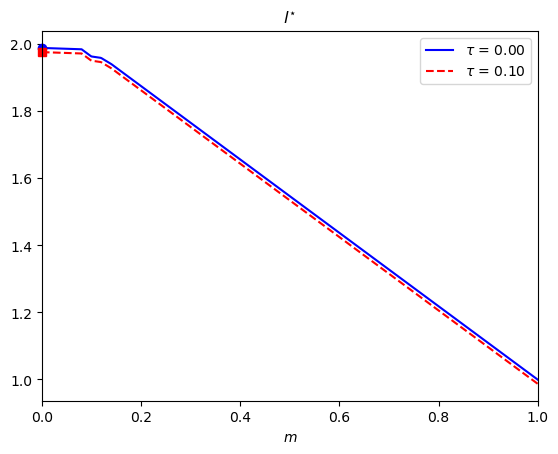

In [11]:
ShowPolicy_CM(policies, m, key="l", x_limits=[0.0, 1.0]);

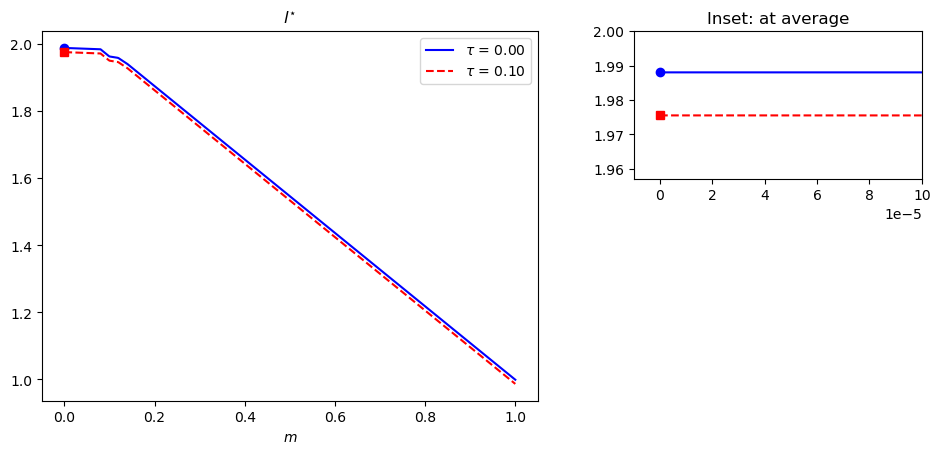

In [12]:
# Show for relevant domain of SME m-outcomes
fig, ax = ShowPolicy_inset(policies, m, key="l",
                           x_limits=[-0.00001, 0.0001],
                           y_limits=[1.957, 2.0],
                           inset_loc=1,
                           bbox_anchor=(0, 0, 1.5, 1),
                           )

## Observation 1

* Extensive margin force: *Matching probability, $b$, uniformly rises with inflation.*

* Intensive margin force: *But lower $m$ can still reduce $b(m)$ outcome.*

   

For example, for average individual:

[]

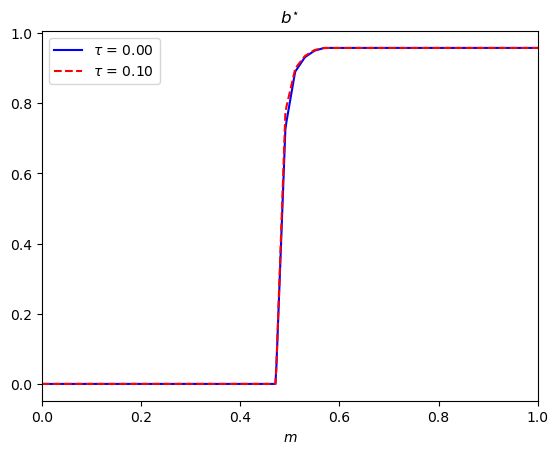

In [13]:
# Show for relevant domain of SME m-outcomes
plt = ShowPolicy(policies, m, key="b", x_limits=[0.0, 1.00])
plt.plot()

[]

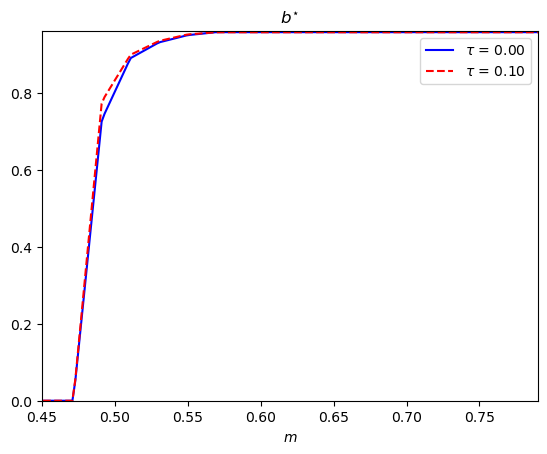

In [14]:
# Zoom in same pic
# Show for relevant domain of SME m-outcomes
plt = ShowPolicy(policies, m, key="b", 
                 x_limits=[0.45, 0.79],
                 y_limits=[0.00, 0.96])
plt.plot()

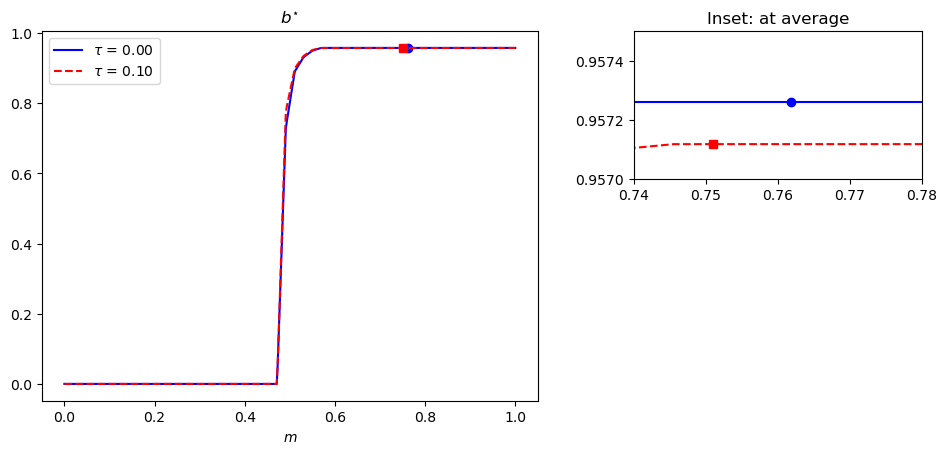

In [15]:
# Show for relevant domain of SME m-outcomes
fig, ax = ShowPolicy_inset(policies, m, key="b", 
                                    x_limits=[0.74, 0.78],
                                    y_limits=[0.957, 0.9575],
                                    inset_loc=1,
                                    bbox_anchor=(0, 0, 1.5, 1),
                                    )

And for the 90-th percentile individual:

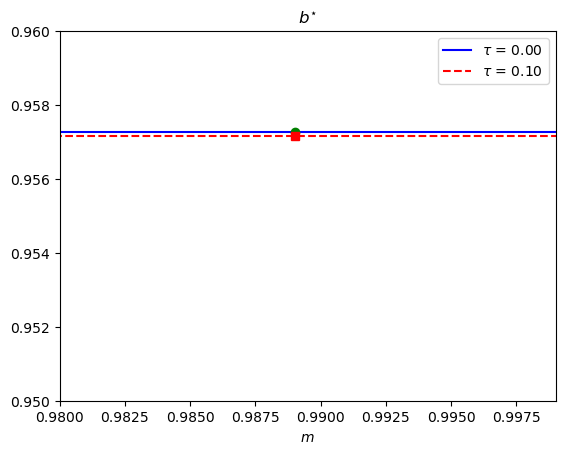

In [16]:
# Show for relevant domain of SME m-outcomes
plt = ShowPolicy(policies, m, key="b", 
           x_limits=[0.98, 0.999], 
           y_limits=[0.95, 0.96])
plt.plot(distro["m_90"][0], distro["b_90"][0], 'og')
plt.plot(distro["m_90"][1], distro["b_90"][1], 'sr');

## Observation 2

*Diminishing money-wealth elasticity of matching probability, diminishes with inflation.*

1. Elasticity of $b$ w.r.t. $m$ falls with $m$, and

2. Elasticity of $b$ w.r.t. $m$ uniformly falls with inflation. 

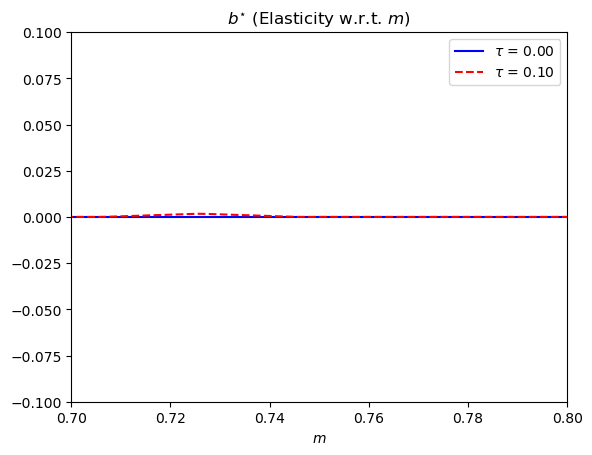

In [17]:
# Show for relevant domain of SME m-outcomes
ShowPolicy(policies, m, key="b", 
           elasticity=True, 
           x_limits=[0.70, 0.80],
           y_limits=[-0.1, 0.1]);

Description of equilibrium behavior:

* As inflation goes up, individuals uniformly are more likely to match regardless of $m$-wealth positions 
        
* But their match rates are less sensitive to their wealth positions; and higher $m$ agents' matching probabilities are even less sensitive to their $m$-wealth position

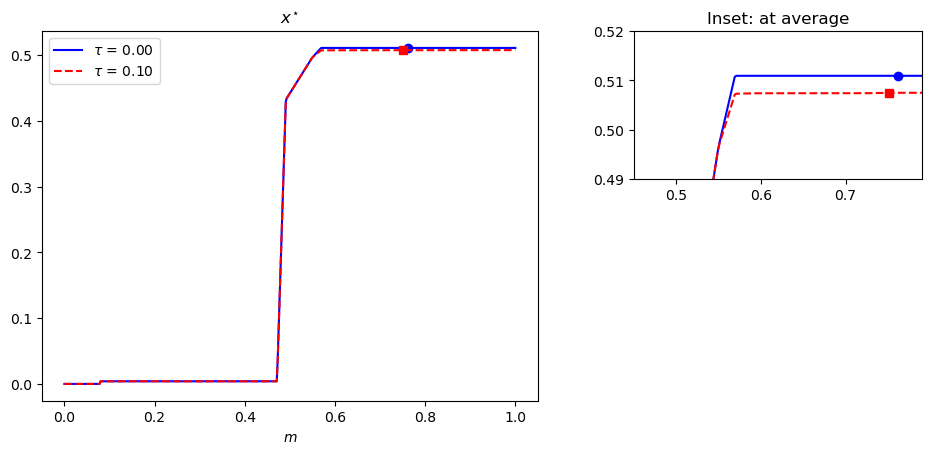

In [18]:
# Show for relevant domain of SME m-outcomes
ShowPolicy_inset(policies, m, key="x", 
                 x_limits=[0.45, 0.79], 
                 y_limits=[0.49, 0.52],
                 inset_loc=1,
                 bbox_anchor=(0, 0, 1.5, 1),
                 );

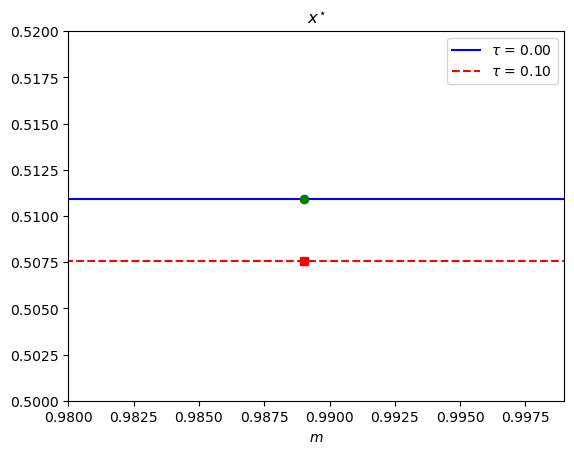

In [19]:
# Show for relevant domain of SME m-outcomes
plt = ShowPolicy(policies, m, key="x", 
           x_limits=[0.98, 0.999], 
           y_limits=[0.5, 0.52])
plt.plot(distro["m_90"][0], distro["x_90"][0], 'og')
plt.plot(distro["m_90"][1], distro["x_90"][1], 'sr');

## Observation 3

*Speed of DM trading $bx/m$ rises with inflation: Expected/average expenditure *per dollar* rises uniformly with inflation.*

* Although $b$ ($x$) uniformly rises (falls) with inflation, each agent optimally would have a per-dollar expected expenditure response function $b\circ x /m$ that uniformly rises with inflation. That is, regardless of their $m$-wealth position, they expect to be "trading faster" and offloading their money balance each time they expect to trade in the DM. [ Combine: **Existing aggregate stat FIGURE from paper!** ]

* In fact, the higher $m$ agents are also less sensitive in their speed of trading w.r.t. $m$ than low $m$ agents. 

* As a consequence, we also see that their participation rates in (entrance to) the CM is more frequent. [ Combine: **Existing aggregate stat FIGURE from paper!** ]


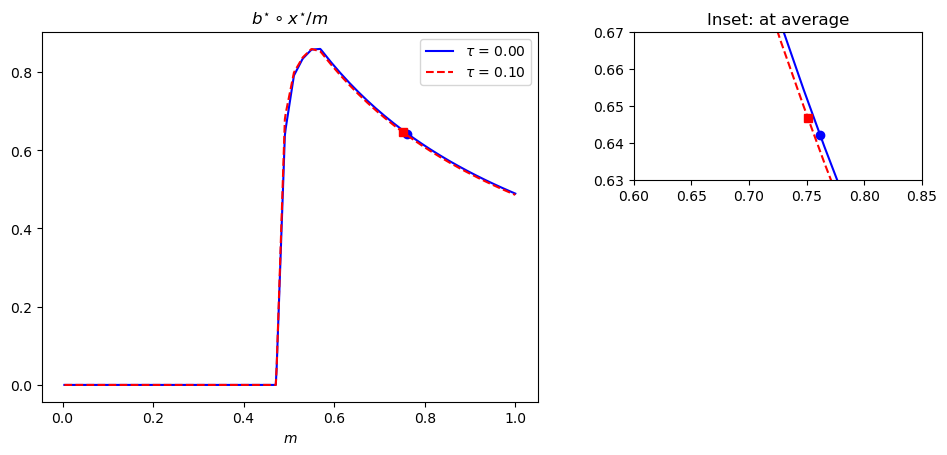

In [34]:
# Show for relevant domain of SME m-outcomes
ShowPolicy_inset(policies, m, key="bxm", 
                 x_limits=[0.6, 0.85],
                 y_limits=[0.63, 0.67],
                 inset_loc=1,
                 bbox_anchor=(0, 0, 1.5, 1),);
# plt.plot()

In [21]:
# # Show for relevant domain of SME m-outcomes
# plt = ShowPolicy(policies, m, key="bxm", 
#                  show_means=False, 
#                  x_limits=[0.75, 0.78],
#                  y_limits=[0.60, 0.70],)
# # bxm0 = distro["bxm"][0].copy()
# # m0 = distro["m"][0].mean()
# # plt.plot(m0, bxm0.mean(), 'og')

# # bxm1 = distro["bxm"][1].copy()
# # m1 = distro["m"][1].mean()
# # plt.plot(m1, bxm1.mean(), 'sr')

# # # bxm0[np.isnan(bxm0)] = 0.0
# # # m0 = distro["m"][0].mean()
# # b0 = distro["b_mean"][0]
# # x0 = distro["x_mean"][0]
# # bxm0 = b0*x0/m0
# # bxm0f = policies["bxm"][0][-2](m0)
# # plt.plot(m0, bxm0f, 'og')
# # # plt.plot(m0, bxm0, 'og')

# # # bxm1 = distro["bxm"][1].copy()
# # # bxm1[np.isnan(bxm1)] = 0.0
# # m1 = distro["m"][1].mean()
# # # plt.plot(m1, policies["bxm"][1][-2](m1), 'sr')

# # b1 = distro["b_mean"][1]
# # x1 = distro["x_mean"][1]
# # bxm1 = b1*x1/m1
# # plt.plot(m1, bxm0f*bxm1/bxm0, 'sr')

# # m0 = distro["m"][0].mean()
# m1 = distro["m"][1].mean()*1.004
# m0 = m1*1.005
# bxm0 = policies["bxm"][0][-2](m0)
# bxm1 = policies["bxm"][1][-2](m1)*1.015

# plt.plot(m0, bxm0, 'ob')
# plt.plot(m1, bxm1, 'sr');

* Although all else equal, matching probability functions shift up with inflation, 

* agents are trading faster uniformly and less sensitive in their match-rates to money positions,

* so we would observe a distribution of money balances that are lower (and also consistent with next Observation 4 below):

    * Geometrically, although the $b$ functions shift up,

    * higher inflation also means that agents tend to move down along the new higher $b$ function.

These opposing effects help explain why:

* on average the *outcomes* $b(m)$ tend to be falling with inflation; and,

* the dispersion in matching probabilities across the $m$-distribution (see the 90/10 dispersion measure) rises with inflation.

In [22]:
m0 = distro["m"][0].mean()
m1 = distro["m"][1].mean()
eb0f = policies["elasticity"]["b"][0][-2]
eb0 = eb0f(m0)
eb1f = policies["elasticity"]["b"][1][-2]
eb1 = eb1f(m1)
ex0f = policies["elasticity"]["x"][0][-2]
ex0  =ex0f(m0)
ex1f = policies["elasticity"]["x"][1][-2]
ex1  =ex1f(m1)
ey0f = policies["elasticity"]["l"][0][-2]
ey0 = ey0f(m0)
ey1f = policies["elasticity"]["l"][1][-2]
ey1 = ey1f(m1)

In [23]:
print([eb0, eb1, ex0, ex1, ey0, ey1])

[array(-1.2810789e-10), array(1.06491223e-10), array(0.), array(0.), array(-0.66181642), array(-0.65271353)]


In [24]:
# Mean bxm elasticities
e_bxm0 = eb0 + ex0 - ey0
e_bxm1 = eb1 + ex1 - ey1
print([e_bxm0, e_bxm1])
print([e_bxm1 - e_bxm0])

[0.6618164214834552, 0.6527135286649042]
[-0.009102892818551034]


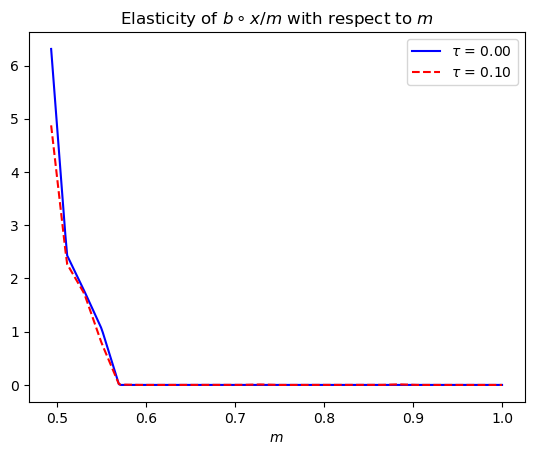

In [44]:
def ebxm(m, experiment, policies):
    """Net elasticity of b*x/m is eb + ex - el"""
    ebf = policies["elasticity"]["b"][experiment][-2]
    eb = ebf(m)
    exf = policies["elasticity"]["x"][experiment][-2]
    ex = exf(m)
    elf = policies["elasticity"]["y"][experiment][-2]
    el = elf(m)
    return {"b": eb, "x": ex, "l": el, "bxm": eb + ex - el}

m_e = m.copy()
m_e[0] = 1e-8

plt.figure()
# plt.xlim([0.45, 0.58])
plt.plot(m_e, ebxm(m_e, 0, policies)["bxm"], '-b',
         label=r"$\tau$ = {:2.2f}".format(
                                        policies["tau"][0]
                                        )
         )
# plt.plot(m0, ebxm(m0, 0, policies)["bxm"], 'ob')
plt.plot(m_e, ebxm(m_e, 1, policies)["bxm"], '--r',
         label=r"$\tau$ = {:2.2f}".format(
                                        policies["tau"][1]
                                        )
         )
# plt.plot(m1, ebxm(m1, 1, policies)["bxm"], 'sr')
plt.xlabel(r"$m$")
plt.title(r"Elasticity of $b \circ x/m$ with respect to $m$")
plt.legend()
# plt.xlim([0.74, 0.7])
# plt.ylim([-0.00001, 0.00001])

## Observation 4

The distributions' support contain real money balance at the start of each $t$ and each CM (post lottery).

In [58]:
# Get set of simulations for different τ's:
y = distro["m"]

*Money-wealth distribution and inflation*. We observe that

* Intermediate-level-balance holders spread out in their masses.

* The measure of the highest-balance agents go down with inflation as agents work less. 

* Additional lotteries can arise as agents in DM expect to trade faster.

* There is less mass in the intermediate $m$ levels as agents trade faster out of the DM and the lottery outcomes pushes them toward the extreme edges of the high/low prize outcomes to begin in the next CM. 

In [ ]:
# Show side-by-side histograms
h = plt.hist(y, 40, histtype='bar', width=0.007, density=True)
plt.legend(policies["tau"], 
           loc='upper center', 
           bbox_to_anchor=(1.1, 0.65, 0.0, 0.0),
           )
plt.title(r"Distribution of $m$ for different $\tau$");

In [ ]:
y[1].std()

In [ ]:
y[0].std()

This observation is associated with the extensive margin effect so that with higher inflation, there can be a higher inequality in $m$-wealth distribution. 

* If we ran an experiments across more inflation regimes we then observe a U-shaped inequality in $m$ balances as a function of inflation.

* [ Combine: **Existing aggregate stat $m$-Gini FIGURE from paper!** ] 

## Observation 5:

*Pricing function shifts up.* 

The observation also corroborates the rise in mean of SME price distributions as inflation rises.

* Highlight this?

* Other S&M models (RWW2018, BR2023, HANK) do not address price dispersion phenomenon

* Implies *price dispersion* is a consequence of directed/competitive search here with equilibrium existence of submarkets with different terms of trade

In [ ]:
ShowPolicy(policies, m, key="p", 
           show_means=False, 
           x_limits=[0.5, 0.90]);

## Observation 6:

Given the SME distribution changes with inflation (see above), these then imply that the 90/10 price-dispersion statistics we presented earlier (in the paper) is also rising with inflation:

* [ Combine: **Existing aggregate stat 90/10 price dispersion FIGURE from paper!** ]

In [63]:
# Get set of simulations for different τ's:
psims = distro["p"]

In [ ]:
# Show side-by-side histograms
h = plt.hist(psims, 50, histtype='bar')
plt.legend(policies["tau"], 
           loc='upper center', 
           bbox_to_anchor=(1.1, 0.65, 0.0, 0.0),
           )
plt.title(r"Distribution of DM prices for different $\tau$");

In [ ]:
psims[1].shape

In [ ]:
plt.figure()
burn = 0
T = np.arange(burn, psims[0].size)
T1 = np.arange(burn, psims[1].size)
plt.plot(T, psims[0][burn::], '.');
plt.plot(T1, psims[1][burn::], 'x');